https://www.jlkgroup.com/careers.html

https://vuno.co/boneage

https://noul.kr/

https://www.deepnoid.com/career

https://www.acryl.ai/recruitment

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score

from datetime import datetime
import cv2
import os
import zipfile
import shutil
from glob import glob 
import glob

from tensorflow.keras.datasets import mnist
import tensorflow.keras.utils as utils


from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator

https://www.kaggle.com/datasets/paultimothymooney/blood-cells

# Project-1

## 경로 설정

In [ ]:
##### Colab

ROOT_DIR = "/content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "/content/blood_cell/TEST_SIMPLE")

In [2]:
##### PC

ROOT_DIR = "content"
DATA_ROOT_DIR = os.path.join(ROOT_DIR, "blood_cell")
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TRAIN")
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST")
TEST_SIMPLE_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, "TEST_SIMPLE")

## 데이터 가져오기

In [ ]:
##### Colab
from google.colab import drive

drive.mount("/content/gdrive/")

shutil.copy(os.path.join("/content/gdrive/MyDrive", "blood_cell.zip"), ROOT_DIR)

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)
    
with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

In [ ]:
##### PC

if os.path.exists(DATA_ROOT_DIR):
    shutil.rmtree(DATA_ROOT_DIR)

with zipfile.ZipFile(os.path.join(ROOT_DIR, "blood_cell.zip"), "r") as target_file:
    target_file.extractall(DATA_ROOT_DIR)

## 전체 데이터 갯수 확인하기

In [4]:
##### 훈련 데이터
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))
    
#### Val 데이터 갯수
test_simple_label_name_list = os.listdir(TEST_SIMPLE_DATA_ROOT_DIR)
print(test_simple_label_name_list)

for label_name in test_simple_label_name_list:
    print("val label :", label_name, " => ", len(os.listdir(os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name))))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
test label : EOSINOPHIL  =>  2497
test label : LYMPHOCYTE  =>  2483
test label : MONOCYTE  =>  2478
test label : NEUTROPHIL  =>  2499
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
test label : EOSINOPHIL  =>  623
test label : LYMPHOCYTE  =>  620
test label : MONOCYTE  =>  620
test label : NEUTROPHIL  =>  624
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
val label : EOSINOPHIL  =>  13
val label : LYMPHOCYTE  =>  6
val label : MONOCYTE  =>  4
val label : NEUTROPHIL  =>  48


## 이미지 shape 설정

In [5]:
IMG_WIDTH = 100 # colab에서 224로 설정
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# val 폴더가 따로 있지만 TRAIN에서 validation_split을 이용해서 사용해보겠다
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

Found 7968 images belonging to 4 classes.
Found 1989 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [8]:
print(train_generator.class_indices)
print(train_generator.num_classes)

{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4


In [9]:
data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

(16, 100, 100, 3) (16,)
[1. 1. 2. 2. 2. 3. 3. 0. 2. 3. 1. 3. 2. 3. 3. 1.]


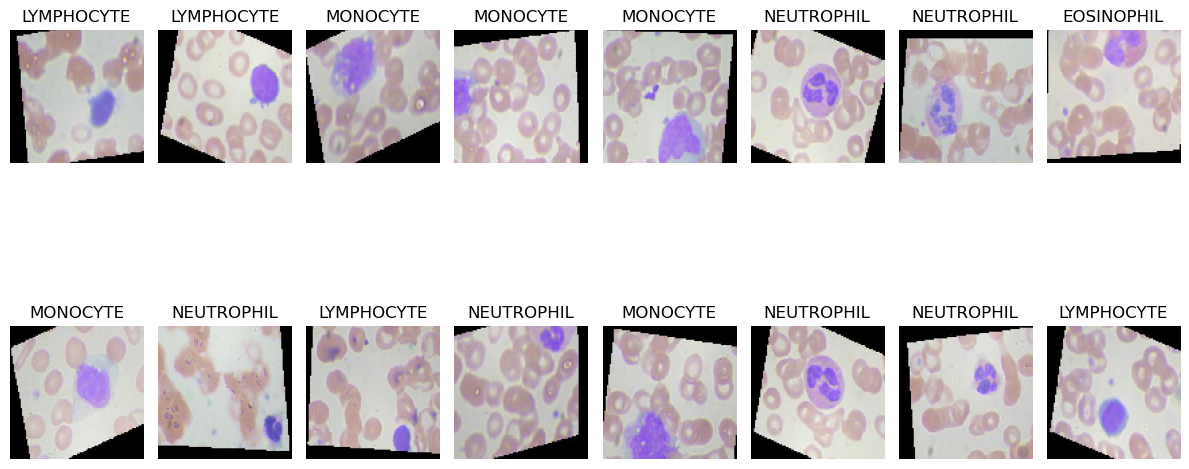

In [10]:
plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

In [11]:
# 가중치 imagenet으로 설정
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9

In [12]:
model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D()) # Flatten() 대신 사용가능

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))


# 4 대신 정답갯수를 알 수 있었던 train_generator.num_classes
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 3,245,332
Trainable params: 3,223,444
Non-

In [16]:
model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-5), metrics=["acc"]) # 2e-5

In [17]:
start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

# epochs = 15
result = model.fit(train_generator, epochs=3, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

Epoch 1/3
249/249 [==============================] - ETA: 0s - loss: 1.1553 - acc: 0.4690
Epoch 1: val_loss improved from inf to 0.99371, saving model to content\


INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


249/249 [==============================] - 98s 378ms/step - loss: 1.1553 - acc: 0.4690 - val_loss: 0.9937 - val_acc: 0.6094
Epoch 2/3
249/249 [==============================] - ETA: 0s - loss: 1.0418 - acc: 0.5274
Epoch 2: val_loss improved from 0.99371 to 0.88329, saving model to content\


INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


249/249 [==============================] - 91s 364ms/step - loss: 1.0418 - acc: 0.5274 - val_loss: 0.8833 - val_acc: 0.6596
Epoch 3/3
249/249 [==============================] - ETA: 0s - loss: 0.9452 - acc: 0.5737
Epoch 3: val_loss improved from 0.88329 to 0.77959, saving model to content\


INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


249/249 [==============================] - 99s 399ms/step - loss: 0.9452 - acc: 0.5737 - val_loss: 0.7796 - val_acc: 0.6983
Elapsed Time :  0:04:48.685358


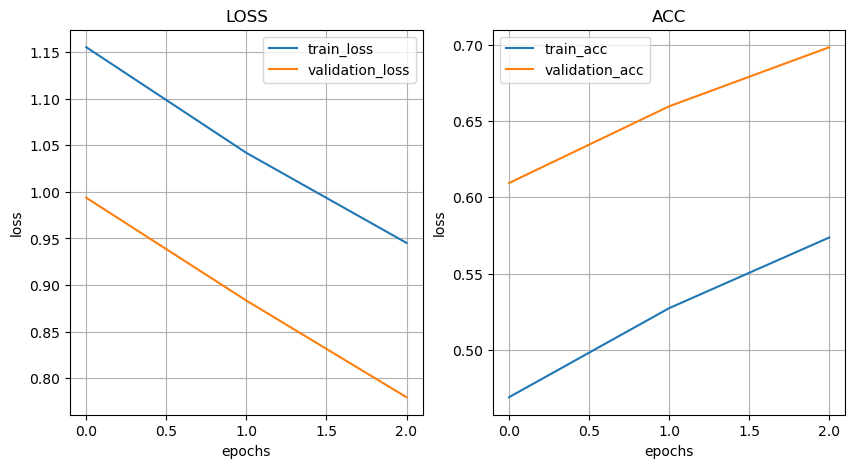

In [18]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

In [19]:
model.evaluate(test_generator)

78/78 [==============================] - 37s 484ms/step - loss: 1.0958 - acc: 0.5553


[1.095780372619629, 0.5552874803543091]

In [20]:
model.evaluate(test_simple_generator)

3/3 [==============================] - 0s 118ms/step - loss: 0.8625 - acc: 0.5915


[0.8624899387359619, 0.591549277305603]

# Project-2

### 모든 데이터를 섞어서 다시 해보자

In [21]:
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [22]:
# Test에 있는 파일들을 Train으로 옮기자
for label_name in test_label_name_list:
    test_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    test_file_list = os.listdir(test_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    
    for test_file in test_file_list:
        shutil.move(os.path.join(test_path, test_file),
                   os.path.join(train_path, test_file))
        move_num = move_num + 1
    
    print(str(move_num) + " is moved into " + label_name + \
         "(TEST => Train)")

623 is moved into EOSINOPHIL(TEST => Train)
620 is moved into LYMPHOCYTE(TEST => Train)
620 is moved into MONOCYTE(TEST => Train)
624 is moved into NEUTROPHIL(TEST => Train)


In [23]:
# TEST_SIMPLE에 있는 파일들을 Train으로 옮기자
for label_name in test_simple_label_name_list:
    test_simple_path = os.path.join(TEST_SIMPLE_DATA_ROOT_DIR, label_name)
    test_simple_file_list = os.listdir(test_simple_path)
    
    train_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    
    move_num = 0
    
    for test_simple_file in test_simple_file_list:
        shutil.move(os.path.join(test_simple_path, test_simple_file),
                   os.path.join(train_path, test_simple_file))
        move_num = move_num + 1
    
    print(str(move_num) + " is moved into " + label_name + \
         "(TEST_SIMPLE => Train)")

13 is moved into EOSINOPHIL(TEST_SIMPLE => Train)
6 is moved into LYMPHOCYTE(TEST_SIMPLE => Train)
4 is moved into MONOCYTE(TEST_SIMPLE => Train)
48 is moved into NEUTROPHIL(TEST_SIMPLE => Train)


In [24]:
##### 훈련 데이터 갯수 확인
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
test label : EOSINOPHIL  =>  3133
test label : LYMPHOCYTE  =>  3108
test label : MONOCYTE  =>  3095
test label : NEUTROPHIL  =>  3171


In [25]:
##### move 할 파일의 비율
MOVE_RATIO = 0.2

In [26]:
label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)

for label_name in label_name_list:
    src = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
    dst = os.path.join(TEST_DATA_ROOT_DIR, label_name)
    
    train_data_file_list = os.listdir(src)
    
    print("============================================")
    print("total [%s] data file nums => [%s]"%(label_name, len(train_data_file_list)))
    
    np.random.shuffle(train_data_file_list)
    print("train data shuffle is done!")
    
    split_num = int(MOVE_RATIO * len(train_data_file_list))
    print("split num => ", split_num)
    
    test_data_file_list = train_data_file_list[0:split_num]
    
    move_num = 0
    for test_data_file in test_data_file_list:
        shutil.move(os.path.join(src, test_data_file),
                   os.path.join(dst, test_data_file))
        move_num = move_num + 1
        
    print("total move num => ", move_num)
    print("=============================================")

total [EOSINOPHIL] data file nums => [3133]
train data shuffle is done!
split num =>  626
total move num =>  626
total [LYMPHOCYTE] data file nums => [3108]
train data shuffle is done!
split num =>  621
total move num =>  621
total [MONOCYTE] data file nums => [3095]
train data shuffle is done!
split num =>  619
total move num =>  619
total [NEUTROPHIL] data file nums => [3171]
train data shuffle is done!
split num =>  634
total move num =>  634


In [27]:
##### 훈련 데이터
train_label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
print(train_label_name_list)

for label_name in train_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TRAIN_DATA_ROOT_DIR, label_name))))

##### 테스트 데이터 갯수
test_label_name_list = os.listdir(TEST_DATA_ROOT_DIR)
print(test_label_name_list)

for label_name in test_label_name_list:
    print("test label :", label_name, " => ", len(os.listdir(os.path.join(TEST_DATA_ROOT_DIR, label_name))))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
test label : EOSINOPHIL  =>  2507
test label : LYMPHOCYTE  =>  2487
test label : MONOCYTE  =>  2476
test label : NEUTROPHIL  =>  2537
['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
test label : EOSINOPHIL  =>  626
test label : LYMPHOCYTE  =>  621
test label : MONOCYTE  =>  619
test label : NEUTROPHIL  =>  634


Found 8007 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2500 images belonging to 4 classes.
Found 0 images belonging to 4 classes.
{'EOSINOPHIL': 0, 'LYMPHOCYTE': 1, 'MONOCYTE': 2, 'NEUTROPHIL': 3}
4
(16, 100, 100, 3) (16,)
[0. 3. 2. 2. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 3.]


Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 50, 50, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 50, 50, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 50, 50, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 50, 50, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 50, 50, 32)       128       
 ation)                                         

                                                                 
 conv_pw_8_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_8_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_dw_9 (DepthwiseConv2D)  (None, 6, 6, 512)        4608      
                                                                 
 conv_dw_9_bn (BatchNormaliz  (None, 6, 6, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_9_relu (ReLU)       (None, 6, 6, 512)         0         
                                                                 
 conv_pw_9 (Conv2D)          (None, 6, 6, 512)         262144    
                                                                 
 conv_pw_9

INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


251/251 [==============================] - 101s 383ms/step - loss: 2.0070 - acc: 0.3034 - val_loss: 1.4188 - val_acc: 0.3725
Epoch 2/3
251/251 [==============================] - ETA: 0s - loss: 1.5247 - acc: 0.3711
Epoch 2: val_loss improved from 1.41884 to 1.23886, saving model to content\


INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


251/251 [==============================] - 102s 404ms/step - loss: 1.5247 - acc: 0.3711 - val_loss: 1.2389 - val_acc: 0.4505
Epoch 3/3
251/251 [==============================] - ETA: 0s - loss: 1.3078 - acc: 0.4259
Epoch 3: val_loss improved from 1.23886 to 1.13283, saving model to content\


INFO:tensorflow:Assets written to: content\assets


INFO:tensorflow:Assets written to: content\assets


251/251 [==============================] - 104s 415ms/step - loss: 1.3078 - acc: 0.4259 - val_loss: 1.1328 - val_acc: 0.5110
Elapsed Time :  0:05:06.370774


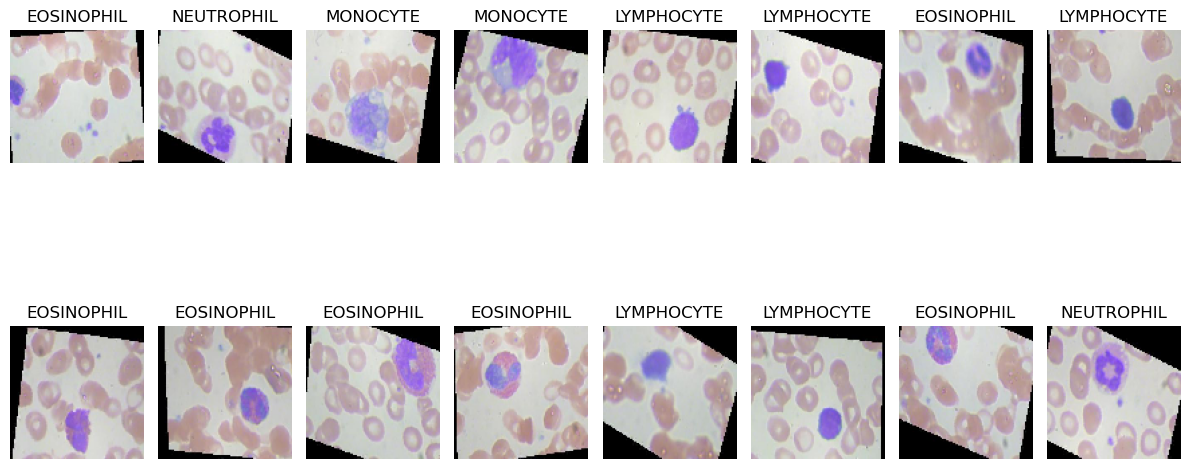

In [28]:
IMG_WIDTH = 100 # colab에서 224로 설정
IMG_HEIGHT = 100

## ImageDataGenerator를 이용하여 데이터 불러오기

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)
test_simple_datagen = ImageDataGenerator(rescale=1./255)

# val 폴더가 따로 있지만 TRAIN에서 validation_split을 이용해서 사용해보겠다
train_generator = train_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="training")

val_generator = validation_datagen.flow_from_directory(directory=TRAIN_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse", subset="validation")

test_generator = test_datagen.flow_from_directory(directory=TEST_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")
test_simple_generator = test_datagen.flow_from_directory(directory=TEST_SIMPLE_DATA_ROOT_DIR, batch_size=32, color_mode='rgb'
                        ,target_size=(IMG_WIDTH, IMG_HEIGHT),
                       class_mode = "sparse")

print(train_generator.class_indices)
print(train_generator.num_classes)

data, label = train_generator.next()

data = data[:16]
label = label[:16]

print(data.shape, label.shape)
print(label)

plt.figure(figsize=(12, 12))
class_dict = {0 : 'EOSINOPHIL', 1 : 'LYMPHOCYTE', 2 : 'MONOCYTE', 3 : 'NEUTROPHIL'}


for i in range(len(label)):
    plt.subplot(4, 8, i+1)
    plt.axis("off")
    plt.title(class_dict[label[i]])
    plt.imshow(data[i])
    
plt.tight_layout()

# 가중치 imagenet으로 설정
pre_trained_model = MobileNet(weights="imagenet", include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

pre_trained_model.summary()

model = Sequential()

model.add(pre_trained_model)

model.add(GlobalAveragePooling2D()) # Flatten() 대신 사용가능

model.add(Dense(16, activation="relu"))
model.add(Dropout(0.5))


# 4 대신 정답갯수를 알 수 있었던 train_generator.num_classes
model.add(Dense(train_generator.num_classes, activation="softmax"))

model.summary()

model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(1e-5), metrics=["acc"]) # 2e-5

start_time = datetime.now()

save_file_name = 'content/'

checkpoint = ModelCheckpoint(save_file_name, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystopping = EarlyStopping(monitor = 'val_loss', patience=5)

# epochs = 15
result = model.fit(train_generator, epochs=3, validation_data=val_generator, callbacks=[checkpoint, earlystopping])

end_time = datetime.now()
print("Elapsed Time : ", end_time - start_time)

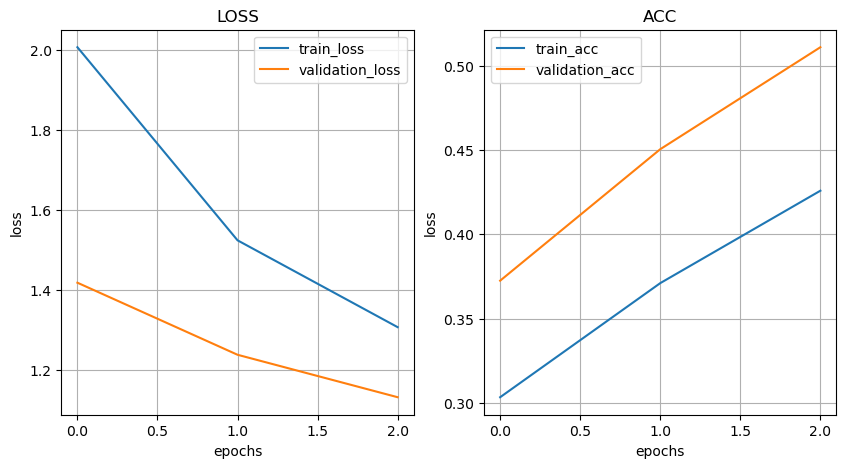

In [29]:
# include_top = True
# MobileNet
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)

plt.title("LOSS")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["loss"], label="train_loss")
plt.plot(result.history["val_loss"], label="validation_loss")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정

plt.subplot(1,2,2)

plt.title("ACC")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.grid()

plt.plot(result.history["acc"], label="train_acc")
plt.plot(result.history["val_acc"], label="validation_acc")
plt.legend(loc="best") # 이름이 있어야 범례를 표시할 수 있음. # label로 이름 지정